In [1]:
#!pip install --quiet pytorch-lightning
#!pip install --quiet tqdm
#!pip install shap


In [2]:
import seaborn as sns  #Visualization
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import math
import matplotlib


import pandas as pd   #preprocessing
import numpy as np
from tqdm.notebook import tqdm
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import shap
import shap.plots



import torch          #modelling
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor



import operator      #random
import os
from IPython.utils import io

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid',palette='muted',font_scale=1.2)

HAPPY_COLORS_PALETTE = ['#01BEFE','#FFDD00','#FF7D00','#FF006D','#ADFF02','#8F00FF']

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize']=12,8

tqdm.pandas()

print(shap.__file__)

D:\Anaconda\lib\site-packages\shap\__init__.py


In [4]:
pl.seed_everything(8);

Global seed set to 8


In [5]:
folder_path = 'Predictions/LSTMSHAP_prediction'

try:
    os.mkdir(f'{folder_path}')
except:
    pass


N_EPOCHS = 50
BATCH_SIZE = 7
SEQUENCE_LENGTH = 7
N_HIDDEN = 64
N_LAYERS = 4
PATIENCE = 10
LEARNING = 0.001


FEATURES_TO_USE = 15
SHAP = True

In [6]:
#returns a dataframe with the selected features, forcing past sales to be used
def features_dataframe(df, corr):
    rows = []
    '''
    ['rec_id', 'datetime', 'year', 'month', 'temp', 'atemp', 'humidity', 'windspeed', 'total_count',
    'season_1', 'season_2', 'season_3', 'season_4', 'is_workingday_0', 'is_workingday_1', 'is_holiday_0',
    'is_holiday_1', 'weather_condition_1', 'weather_condition_2', 'weather_condition_3', 'weekday_0',
    'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'day']
    
    '''

    for _, row in df.iterrows():
        row_data = dict(
            total_count = row.total_count,
        )
        for column in corr:
            row_data[column] = row[column]
            
        rows.append(row_data)
    
    features_df = pd.DataFrame(rows)

    return features_df


#spliits the data in test and train
def train_test_spliter(ratio,features_df ):
    train_size = int(len(features_df)-ratio)
    train_df, test_df = features_df[:train_size], features_df[train_size + 1:]

    return train_df, test_df, train_size

#applies the minmaxscaler to the test and train dataframes
def data_scaler(train_df,test_df):
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = scaler.fit(train_df)

    train_df = pd.DataFrame(
        scaler.transform(train_df),
        index = train_df.index,
        columns = train_df.columns
        )

    test_df = pd.DataFrame(
        scaler.transform(test_df),
        index = test_df.index,
        columns = test_df.columns
        )

    return train_df, test_df, scaler

#create sequences to be used with lstm
def create_sequences (input_data:pd.DataFrame, target_column, sequence_length):
    sequences = []
    data_size = len(input_data)

    for i in (range(data_size - sequence_length)):

        sequence = input_data[i:i+sequence_length]

        label_position = i + sequence_length
        label = input_data.iloc[label_position][target_column]

        sequences.append((sequence,label))
    
    return sequences

#reverts the minmaxscaler effect
def descale(descaler, values):
    values_2d=np.array(values)[:,np.newaxis]
    
    return descaler.inverse_transform(values_2d).flatten()


#transform the {sequence,label} dictionary into "tabular data" as a dataframe
def dict_to_dataframe(dict_list,seq_size):
    
    column_names = []
    data = []
    
    for d in dict_list:
        features = d['sequence'].numpy().flatten()
        label = d['label'].numpy()
        data.append(np.concatenate((features, label), axis=None))
        
    df = pd.DataFrame(data)
    
    for j in range(seq_size):
        if seq_size-j >= 10:
            day_column_names = str(seq_size-j) + 'day_back'+'_' + train_df.columns
            column_names.extend(day_column_names)
        else:
            day_column_names = '0' + str(seq_size-j) + 'day_back'+'_' + train_df.columns
            column_names.extend(day_column_names)
        
    cols = [column_names + ['target']]
    df.columns = cols
    
    return df

    
    
#function used to predict the data values in a way the shap.KernelExplainer function can accept it 
def LSTM_SHAP(array):
    with torch.no_grad():

        predictions_shap= list(array[:SEQUENCE_LENGTH,0])
        label_shap=[]

        train_df = pd.DataFrame(array)
        #features_df.columns = features

        train_sequences = create_sequences(train_df,0,SEQUENCE_LENGTH)

        data_module = SalesDataModule(train_sequences, test_sequences, batch_size = BATCH_SIZE)

        train_dataset = Dataset(train_sequences)

        data_module.setup()

        for item in train_dataset:
            sequence = item['sequence']
            label = item['label']
            _,output = trained_model(sequence.unsqueeze(dim=0))
            predictions_shap.append(output.item())
            label_shap.append(label.item())

        output = np.array(predictions_shap)

    return output



def return_shap_features(shap_values,train_df, number_to_return):
    shapdict = {}
    for k in train_df.columns:
        shapdict[k] = 0
        shapdict[f'{k}_count'] = 0


    for i in shap_values:
        for f in range(len(train_df.columns)):
            shapdict[train_df.columns[f]] += abs(i[f])
            shapdict[f'{train_df.columns[f]}_count'] += 1

    avg_n0_shap = {}

    for key in range(0,len(shapdict.keys()),2):
        if shapdict[list(shapdict.keys())[key+1]] != 0 and shapdict[list(shapdict.keys())[key]] != 0:
            avg_n0_shap[list(shapdict.keys())[key]] = shapdict[list(shapdict.keys())[key]]/shapdict[list(shapdict.keys())[key+1]]

    sorted_avg_shap = dict(sorted(avg_n0_shap.items(), key=operator.itemgetter(1), reverse=True))
    
    top_features = dict(sorted(avg_n0_shap.items(), key=lambda item: item[1], reverse=True)[:number_to_return])
    
    return sorted_avg_shap, top_features
    
###########################################################################################################
#______________________________________________Model Creation______________________________________________
###########################################################################################################

class Dataset(Dataset):

    def __init__(self,sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self,idx):
        sequence, label = self.sequences[idx]

        return dict(
            sequence = torch.Tensor(sequence.to_numpy()),
            label = torch.tensor(label).float()
        )

class SalesDataModule(pl.LightningDataModule):

    def __init__(self, train_seqeunces,test_sequences, batch_size=8):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size

    def setup(self,stage=None):
        self.train_dataset = Dataset(self.train_sequences)
        self.test_dataset = Dataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers = 0
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = 1,
            shuffle = False,
            num_workers = 0
        )


class SalesPredictionModel(nn.Module):
    def __init__(self, n_features, n_hidden = N_HIDDEN, n_layers = N_LAYERS):
        super().__init__()
        self.n_hidden = n_hidden

        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            batch_first = True,
            num_layers = n_layers,
            dropout = 0.2
        )
        self.regressor = nn.Linear(n_hidden,1)

    def forward(self,x):
        self.lstm.flatten_parameters()

        _, (hidden, _) = self.lstm(x)
        out = hidden[-1]
        
        return self.regressor(out)
    

class SalesPredictor(pl.LightningModule):

    def __init__(self, n_features: int):
        super().__init__()
        self.model=SalesPredictionModel(n_features)
        self.criterion = nn.MSELoss()

    def forward(self, x, labels= None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels.unsqueeze(dim=1))
        return loss, output
    
    def training_step(self, batch, batch_index):
        sequences = batch['sequence']
        labels = batch['label']

        loss, outputs = self(sequences, labels)
        self.log('train_loss', loss, prog_bar = True, logger=False)
        return loss

    def validation_step(self, batch, batch_index):
        sequences = batch['sequence']
        labels = batch['label']

        loss, outputs = self(sequences, labels)
        self.log('val_loss', loss, prog_bar = True, logger=False)
        return loss

    def test_step(self, batch, batch_index):
        sequences = batch['sequence']
        labels = batch['label']

        loss, outputs = self(sequences, labels)
        self.log('test_loss', loss, prog_bar = True, logger=False)
        return loss

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr = LEARNING)
        

In [7]:
#import data
Bikes_df = pd.read_csv('Bike_Sharing_Daily.csv')


In [8]:
if SHAP == True:
    #makes SHAP calculations for all stores inside the rossmann_treated dataset if removed the [:1]

    #to omit outputs
    #with io.capture_output() as captured:
    df = Bikes_df.drop(columns  = 'datetime')
    sales_dependencies = {}
    dic = {}

    #return all columns names ('features') except for customers, since it's not an available 
    #information for future points
    features_df = features_dataframe(df,list(df.columns)) 
    #returns dataframe with the features to be analised

    #split into test and train and minmaxscaler
    train_df, test_df, train_size =  train_test_spliter(99,features_df)
    train_df, test_df, scaler = data_scaler(train_df,test_df)
    #make sequences with the data
    train_sequences = create_sequences(train_df,'total_count',SEQUENCE_LENGTH)
    test_sequences = create_sequences (test_df,'total_count',SEQUENCE_LENGTH)

    #trains the model and store the most recent checkpoints removing previous ones if existing
    data_module = SalesDataModule(train_sequences, test_sequences, batch_size = BATCH_SIZE)
    data_module.setup()
    train_dataset = Dataset(train_sequences)
    test_dataset = Dataset(test_sequences)
    model = SalesPredictor(n_features = train_df.shape[1])

    try:
        os.remove(f"{folder_path}/Checkpoints/Bike_sharing_LSTMSHAP.ckpt")
    except:
        pass

    checkpoint_callback = ModelCheckpoint(
        dirpath = f'{folder_path}/Checkpoints',
        filename = f'Bike_sharing_LSTMSHAP',
        save_top_k = 1,
        verbose = False ,
        monitor = 'val_loss',
        mode = 'min'
    )
    logger = TensorBoardLogger('lightning_logs', name = 'btc-price')
    early_stopping_callback = EarlyStopping(monitor= 'val_loss', patience = PATIENCE)
    trainer = pl.Trainer(
        logger = logger,
        callbacks=[early_stopping_callback, checkpoint_callback],
        max_epochs = N_EPOCHS,
        gpus = 0,
    )
    trainer.fit(model, data_module)

    #load the best model from checkpoint
    trained_model = SalesPredictor.load_from_checkpoint(
    f'{folder_path}/Checkpoints/Bike_sharing_LSTMSHAP.ckpt',
    n_features = train_df.shape[1]
    )
    #uses kmeans to reduce dimentionality of the data while losing the least information possible
    kmeans = shap.kmeans(train_df,5)
    #explainer
    explainer = shap.KernelExplainer(LSTM_SHAP, kmeans)
    #explanation
    shap_values = explainer.shap_values(train_df[-365:])
    #return a FEATURES_TO_USE numpber of features ordered by average shap value
    sorted_avg_shap, top_features_dic = return_shap_features(shap_values,train_df,FEATURES_TO_USE)


    shap_per_feature = pd.DataFrame.from_dict(sorted_avg_shap, orient='index', columns=['Importance'])
    shap_per_feature.to_csv(f"{folder_path}/Features_LSTMSHAP.csv")



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type                 | Params
---------------------------------------------------
0 | model     | SalesPredictionModel | 123 K 
1 | criterion | MSELoss              | 0     
---------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.495     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


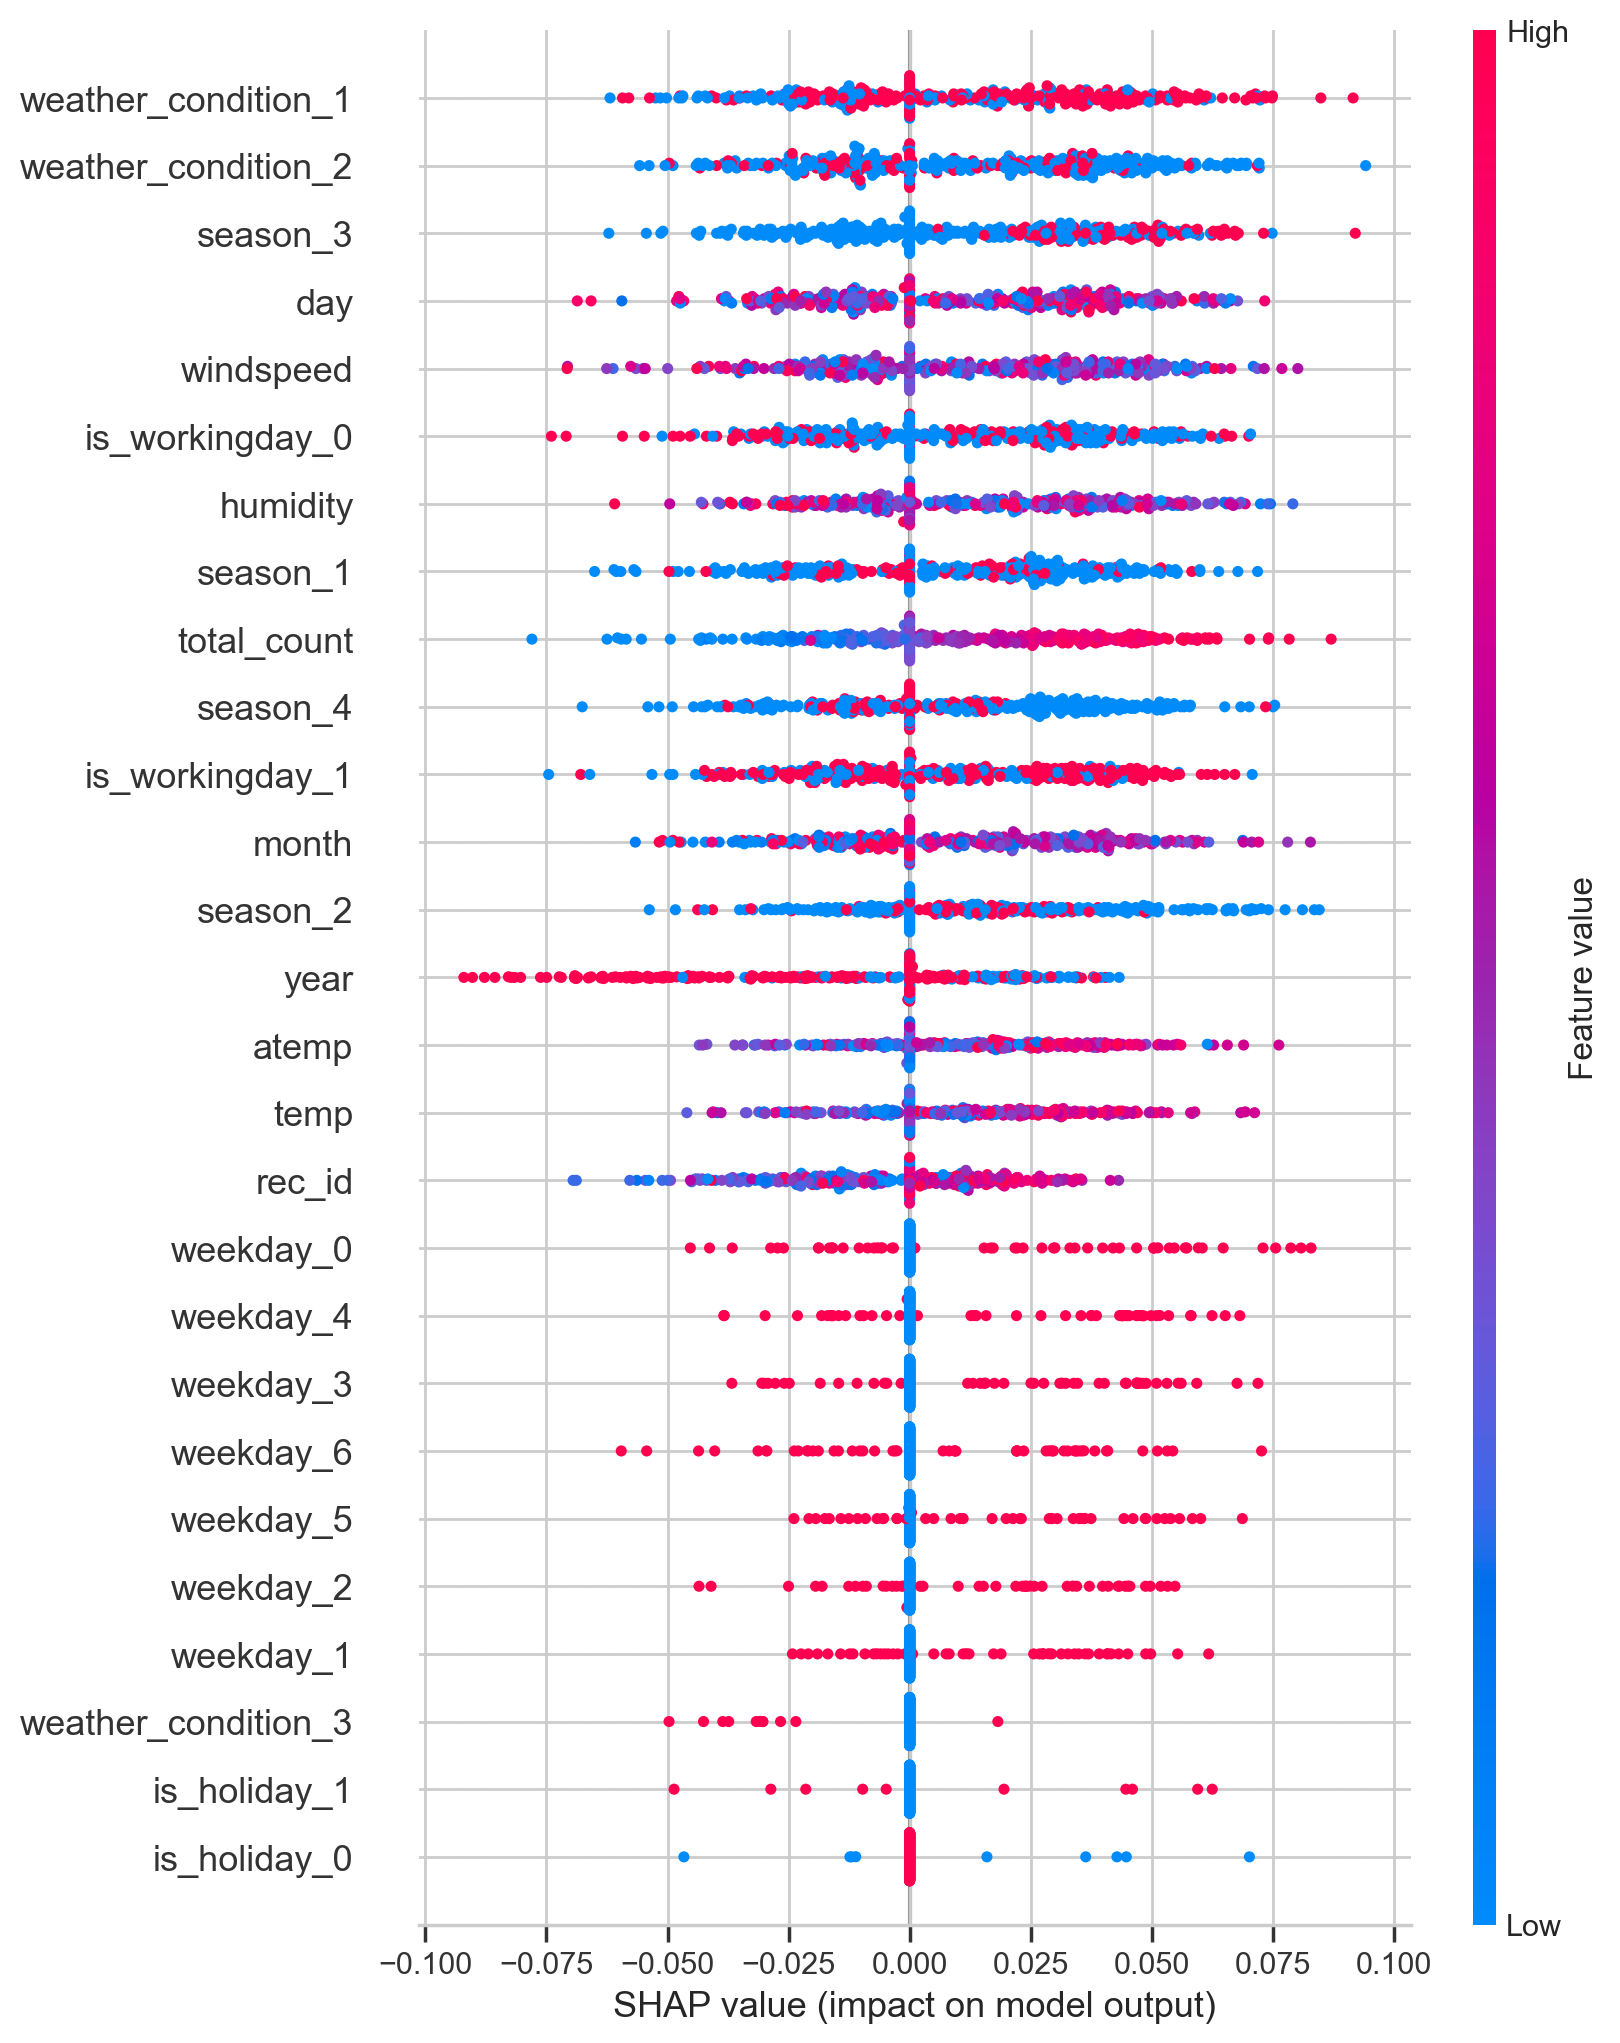

In [9]:
Explanation = shap.Explanation(values=shap_values, data=train_df[-365:])
shap.plots.beeswarm(Explanation,max_display = 28)

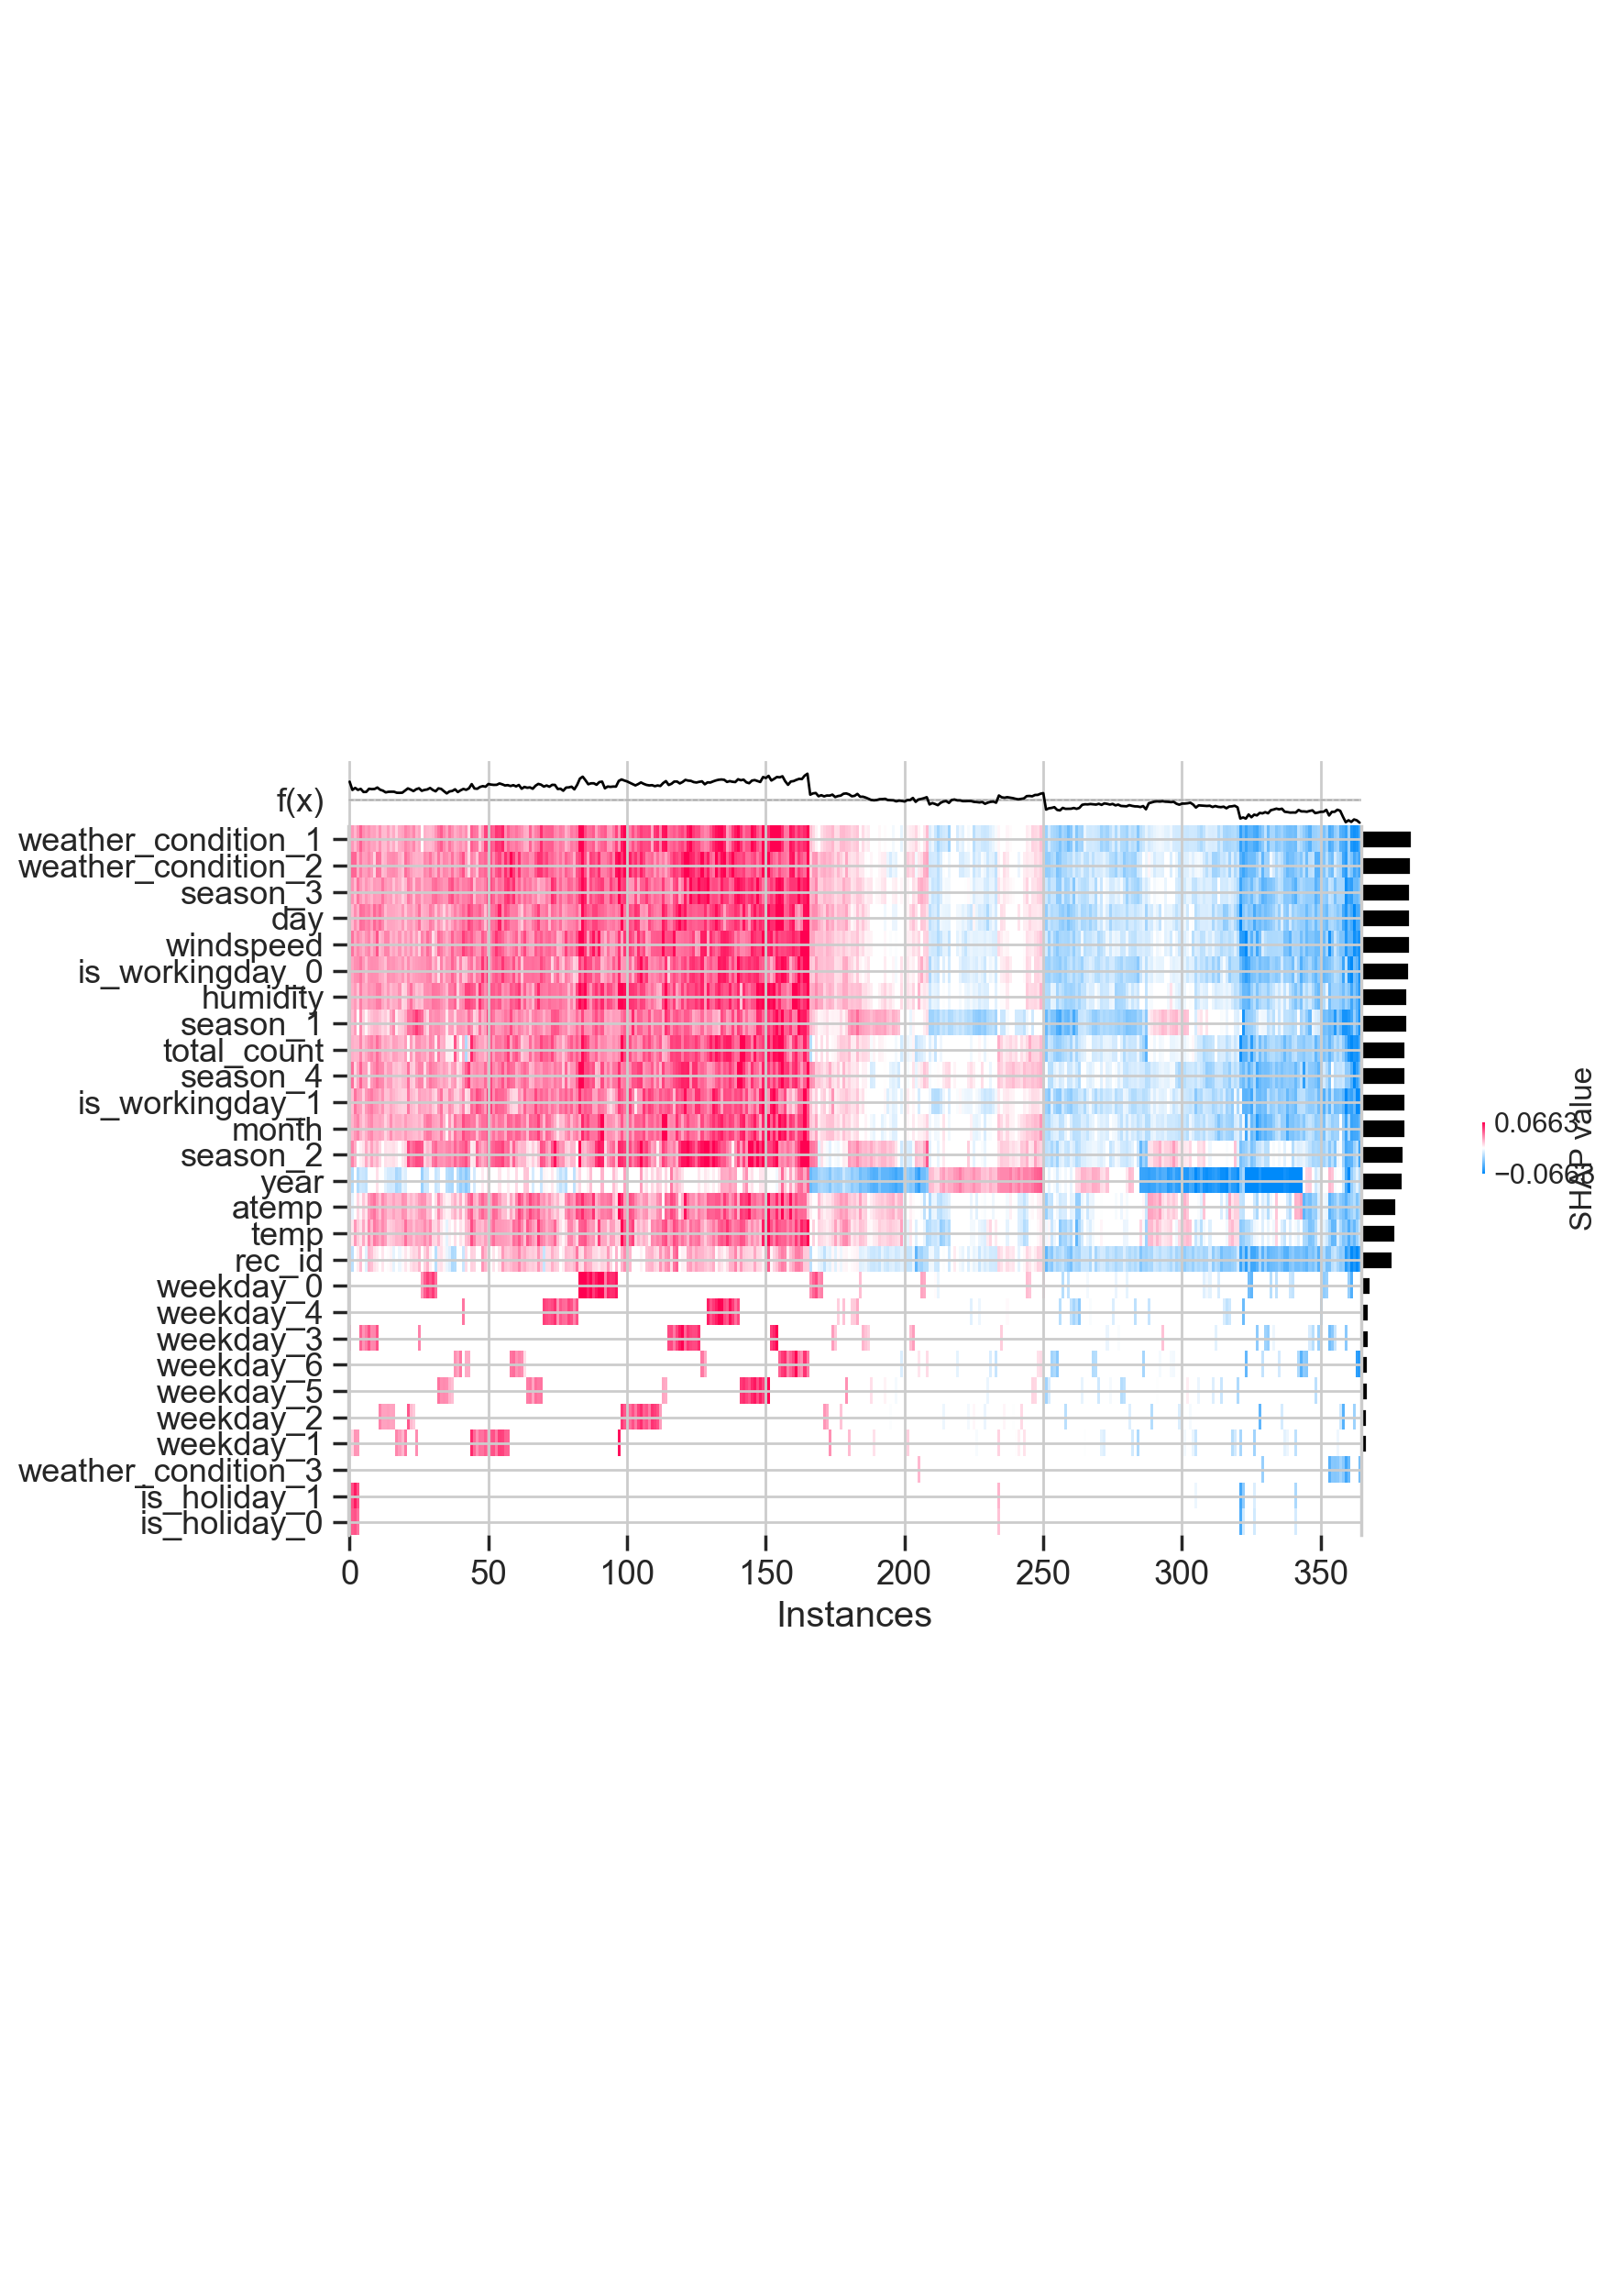

In [10]:
Explanation = shap.Explanation(values=shap_values, data=train_df[-365:])
Explanation.feature_names = list(Explanation.data.columns)
shap.plots.heatmap(Explanation,max_display=28)

  0%|          | 0/1 [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type                 | Params
---------------------------------------------------
0 | model     | SalesPredictionModel | 120 K 
1 | criterion | MSELoss              | 0     
---------------------------------------------------
120 K     Trainable params
0         Non-trainable params
120 K     Total params
0.484     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Features selected: ['day', 'weather_condition_2', 'weekday_4', 'year', 'is_workingday_1', 'season_3', 'weekday_2', 'season_4', 'season_1', 'weather_condition_1', 'is_holiday_0', 'season_2', 'temp', 'rec_id', 'is_holiday_1']


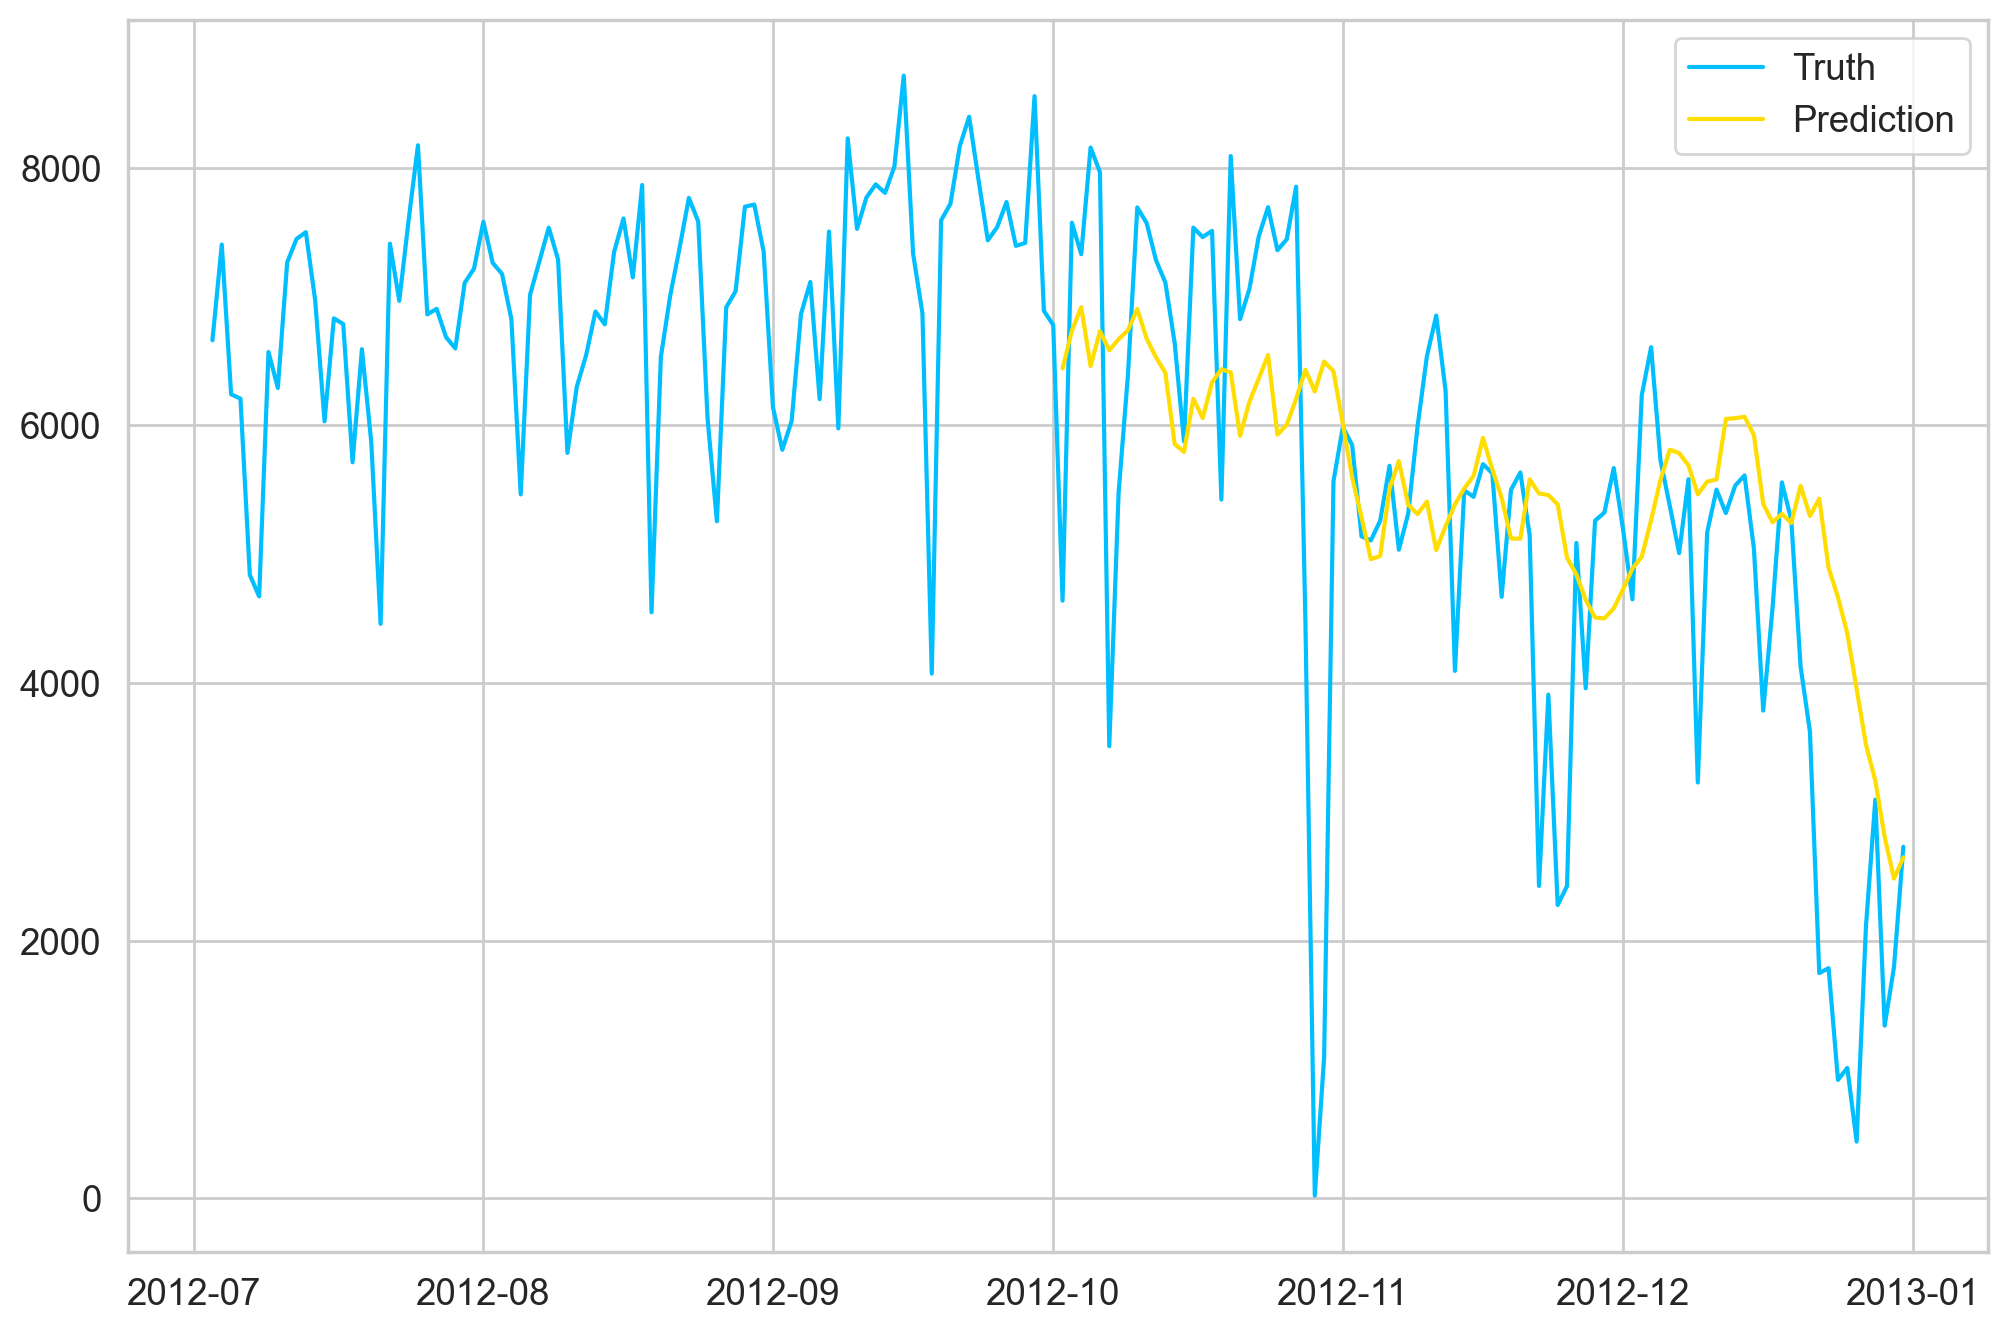

In [11]:
Bikes_df = pd.read_csv('Bike_Sharing_Daily.csv')

for i in tqdm(range(1)):

    error_ds = []

    df = Bikes_df.drop(columns  = 'datetime')

    sales_dependencies = {}

    dic = {}
    top_features_df = pd.read_csv(f"{folder_path}/Features_LSTMSHAP.csv") 
    top_features = list(top_features_df.iloc[:,0])

        #remove possible duplicates
    top_features = list(set(top_features))[:FEATURES_TO_USE] 

    features_df = features_dataframe(df,top_features)

    train_df, test_df, train_size =  train_test_spliter(99,features_df)
    train_df, test_df, scaler = data_scaler(train_df,test_df)
    train_sequences = create_sequences (train_df,'total_count',SEQUENCE_LENGTH)
    test_sequences = create_sequences (test_df,'total_count',SEQUENCE_LENGTH)
    data_module = SalesDataModule(train_sequences, test_sequences, batch_size = BATCH_SIZE)
    data_module.setup()

    train_dataset = Dataset(train_sequences)
    test_dataset = Dataset(test_sequences)

    model = SalesPredictor(n_features = train_df.shape[1])

    try:
        os.remove(f"{folder_path}/Checkpoints/checkpoint_BikeLSTMSHAP.ckpt")
    except:
        pass

    checkpoint_callback = ModelCheckpoint(
        dirpath = f'{folder_path}/Checkpoints',
        filename = f'checkpoint_BikeLSTMSHAP',
        save_top_k = 1,
        verbose = False ,
        monitor = 'val_loss',
        mode = 'min'
    )

    logger = TensorBoardLogger('lightning_logs', name = 'btc-price')
    early_stopping_callback = EarlyStopping(monitor= 'val_loss', patience = PATIENCE)

    trainer = pl.Trainer(
        logger = logger,
        callbacks=[early_stopping_callback, checkpoint_callback],
        max_epochs = N_EPOCHS,
        gpus = 0,
    )

    trainer.fit(model, data_module)

    trained_model = SalesPredictor.load_from_checkpoint(
    f'{folder_path}/Checkpoints/checkpoint_BikeLSTMSHAP.ckpt',
    n_features = train_df.shape[1]
    )

    predictions = []
    labels = []

    for item in test_dataset:
        sequence = item['sequence']
        label = item['label']
        _,output = trained_model(sequence.unsqueeze(dim=0))
        predictions.append(output.item())
        labels.append(label.item())


    descaler = MinMaxScaler()
    descaler.min_, descaler.scale_ = scaler.min_[0], scaler.scale_[0]

    predictions_descaled = descale(descaler,predictions)
    labels_descaled = descale(descaler,labels)

    test_data = df[train_size+1:]
    test_sequences_data = test_data.iloc[SEQUENCE_LENGTH:]

    dates = matplotlib.dates.date2num(Bikes_df.iloc[-len(predictions_descaled):].datetime.tolist())
    full_dates = matplotlib.dates.date2num(Bikes_df.datetime.tolist())

    predictions_descaled = np.where(predictions_descaled<0, 0, predictions_descaled)


    dic = {}
    dic[f'store_truth'] = Bikes_df['total_count']
    dic[f'store_truth_dates'] = full_dates
    truth_df = pd.DataFrame.from_dict(dic)
    truth_df.to_csv(f"{folder_path}/truth.csv",index = False)

    dic= {}
    dic[f'store_pred'] = predictions_descaled
    dic[f'store_pred_dates'] = dates
    prediction_df = pd.DataFrame.from_dict(dic)
    prediction_df.to_csv(f"{folder_path}/prediction_BikeLSTMSHAP.csv",index = False)


    print('Features selected:',top_features)
    plt.plot_date(truth_df.iloc[-2*len(prediction_df):,1],truth_df.iloc[-2*len(prediction_df):,0],'-', label='Truth')
    plt.plot_date(prediction_df.iloc[:,1],prediction_df.iloc[:,0],'-',label ='Prediction')
    plt.legend()
    plt.show();

In [ ]:
plt.plot_date(truth_df.iloc[-2*len(prediction_df):,1],truth_df.iloc[-2*len(prediction_df):,0],'-', label='Truth')
plt.plot_date(prediction_df.iloc[:,1],prediction_df.iloc[:,0],'-',label ='Prediction')
plt.legend();